In [1]:
from opendr.perception.object_detection_2d.nanodet.algorithm.nanodet.data.transform.warp import ShapeTransform
from opendr.engine.target import BoundingBox
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET

import numpy as np
import os
import matplotlib.pyplot as plt
import math
import random
import cv2
import pandas as pd
from PIL import Image

random.seed("123")

/home/manos/Thesis/opendr/venv_new/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.13.1+cu117` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


# Functions

In [2]:
def write_to_xml(image_name, bboxes, dabase_name, save_folder, xml_template='pascal_voc_template.xml'):
    # read xml file
    tree = ET.parse(xml_template)
    root = tree.getroot()

    # modify
    folder = root.find('folder')
    folder.text = 'Annotations'

    fname = root.find('filename')
    fname.text = image_name

    src = root.find('source')
    database = src.find('database')
    database.text = dabase_name

    h, w = bboxes[0][5]
    d = 3
    size = root.find('size')
    width = size.find('width')
    width.text = str(w)
    height = size.find('height')
    height.text = str(h)
    depth = size.find('depth')
    depth.text = str(d)

    for box in bboxes:
        # append object
        obj = ET.SubElement(root, 'object')

        name = ET.SubElement(obj, 'name')
        name.text = box[0]

        pose = ET.SubElement(obj, 'pose')
        pose.text = 'Unspecified'

        truncated = ET.SubElement(obj, 'truncated')
        truncated.text = str(0)

        difficult = ET.SubElement(obj, 'difficult')
        difficult.text = str(0)

        bndbox = ET.SubElement(obj, 'bndbox')

        xmin = ET.SubElement(bndbox, 'xmin')
        xmin.text = str(int(box[1]))

        ymin = ET.SubElement(bndbox, 'ymin')
        ymin.text = str(int(box[2]))

        xmax = ET.SubElement(bndbox, 'xmax')
        xmax.text = str(int(box[3]))

        ymax = ET.SubElement(bndbox, 'ymax')
        ymax.text = str(int(box[4]))

    # save .xml to anno_path
    anno_path = os.path.join(save_folder, "annotations", image_name.split('.')[0] + '.xml')
    tree.write(anno_path)

In [3]:
def calculate_iou(bbox1, bbox2):
    x1, y1, x2, y2 = bbox1
    x1_, y1_, x2_, y2_ = bbox2
    # Calculate the intersection coordinates
    xi1, yi1, xi2, yi2 = max(x1, x1_), max(y1, y1_), min(x2, x2_), min(y2, y2_)
    # Calculate the area of the intersection
    intersection_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    # Calculate the area of both bounding boxes
    bbox1_area = (x2 - x1) * (y2 - y1)
    bbox2_area = (x2_ - x1_) * (y2_ - y1_)
    # Calculate the union area
    union_area = bbox1_area + bbox2_area - intersection_area
    # Calculate the IoU
    iou = intersection_area / union_area
    return iou


def is_valid_bbox(bboxes_list, bbox, th):
    for i, box in enumerate(bboxes_list):
        iou = calculate_iou(bbox, box)
        if iou>th:
            return False
    return True


In [4]:
def random_crop(image, crop_size_ratio=0):
    width, height, ch = image.shape
    if isinstance(crop_size_ratio, tuple):
        crop_size_ratio_x = crop_size_ratio[0]
        crop_size_ratio_y = crop_size_ratio[1]
    else:
        crop_size_ratio_x = crop_size_ratio
        crop_size_ratio_y = crop_size_ratio
    if crop_size_ratio_x > 1 or crop_size_ratio_y > 1:
        raise ValueError("Crop size ratio should be smaller than 1")
    after_crop_pixels_y = random.randint(height - int(width*crop_size_ratio_y), height)
    after_crop_pixels_x = random.randint(width - int(width*crop_size_ratio_x), width)
    x = int(width/2)
    y = int(height/2)
    left = int(x - after_crop_pixels_x/2)
    right = int(left + after_crop_pixels_x)
    top = int(y - after_crop_pixels_y/2)
    bottom = int(top + after_crop_pixels_y)
    return image[left:right, top:bottom, :]

def random_stretch(image, stretch_ratio_th=(1, 1)):
    if isinstance(stretch_ratio_th[0], tuple):
        resize_ratio_th_x_neg = stretch_ratio_th[0][0]
        resize_ratio_th_x_pos = stretch_ratio_th[0][1]
        resize_ratio_th_y_neg = stretch_ratio_th[1][0]
        resize_ratio_th_y_pos = stretch_ratio_th[1][1]
    else:
        resize_ratio_th_x_neg = stretch_ratio_th[0]
        resize_ratio_th_x_pos = stretch_ratio_th[0]
        resize_ratio_th_y_neg = stretch_ratio_th[1]
        resize_ratio_th_y_pos = stretch_ratio_th[1]
    width, height, ch = image.shape
    stretch_ration_x = random.uniform(resize_ratio_th_x_neg, resize_ratio_th_x_pos)
    stretch_ration_y = random.uniform(resize_ratio_th_y_neg, resize_ratio_th_y_pos)
    new_dimensions = (int(height*stretch_ration_y), int(width*stretch_ration_x)) #C format
    return cv2.resize(image, dsize=new_dimensions, interpolation=cv2.INTER_LINEAR)

def resize(image, resize_ratio=1):
    width, height, ch = image.shape
    new_dimensions = (int(height*resize_ratio), int(width*resize_ratio)) #C format
    return cv2.resize(image, new_dimensions, interpolation=cv2.INTER_LINEAR)

def random_resize(image, resize_ratio_th=1):
    if isinstance(resize_ratio_th, tuple):
        resize_ratio_th_neg = resize_ratio_th[0]
        resize_ratio_th_pos = resize_ratio_th[1]
    else:
        resize_ratio_th_neg = resize_ratio_th
        resize_ratio_th_pos = resize_ratio_th
    resize_ratio = random.uniform(resize_ratio_th_neg, resize_ratio_th_pos)
    return resize(image, resize_ratio)

def random_pad(image, pad_th=0):
    pad = random.uniform(0, pad_th)
    width, height, ch = image.shape
    top = int(height*random.uniform(0, pad_th))
    bottom = int(height*random.uniform(0, pad_th))
    left = int(width*random.uniform(0, pad_th))
    right = int(width*random.uniform(0, pad_th))
    return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_WRAP)

def random_rotate_image(images, angle_th=0):
    if isinstance(angle_th, tuple):
        angle_th_neg = angle_th[0]
        angle_th_pos = angle_th[1]
    else:
        angle_th_neg = -angle_th
        angle_th_pos = angle_th
    # Generate a random angle between "angle_th_neg" and "angle_th_pos" degrees
    angle = random.uniform(angle_th_neg, angle_th_pos)
    new_images = []
    for image in images:
        # Calculate the dimensions needed to maintain the original size
        width, height, ch = image.shape

        cos_angle = np.abs(np.cos(np.radians(angle)))
        sin_angle = np.abs(np.sin(np.radians(angle)))
        new_w = int((height * sin_angle) + (width * cos_angle))
        new_h = int((height * cos_angle) + (width * sin_angle))

        center = (width // 2, height // 2)
        # Get the rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D((center[1], center[0]), angle, 1.0)
        # Update the translation part of the rotation matrix to keep the new dimensions
        rotation_matrix[0, 2] += (new_h / 2) - center[1]
        rotation_matrix[1, 2] += (new_w / 2) - center[0]
        # print("+++++++++++++++++++++++++++++++++++++++++")
        # print(rotation_matrix)
        # print("+++++++++++++++++++++++++++++++++++++++++")
        # Rotate the image
        new_images.append(cv2.warpAffine(image, rotation_matrix, (new_h, new_w), flags=cv2.INTER_LINEAR))
    return new_images

def random_flip(image, flip_th=0):
    if isinstance(flip_th, tuple):
        flip_vert = flip_th[0]
        flip_hor = flip_th[1]
    else:
        flip_vert = flip_th
        flip_hor = flip_th
    if random.random() < flip_hor:
        image = cv2.flip(image, 1)
    if random.random() < flip_vert:
        image = cv2.flip(image, 0)
    return image

def augmentations(image, flip_th=0, scale_th=1, stretch_th=(1, 1), crop_th=0, pad_th=0, angle_th=0):
    image = random_flip(image, flip_th)
    image = random_resize(image, scale_th)
    image = random_stretch(image, stretch_th)
    image = random_crop(image, crop_th)
    image_pad = random_pad(image, pad_th)
    images = random_rotate_image([image_pad, image], angle_th)
    return images[0], images[1]

In [5]:
def update_mask(mask, new_position, mask_pixel_blur, new_image_shape, image_mask=None):
    if image_mask is not None:
        mask[image_mask[:,:,0]==0] = 0
        image_mask[image_mask>20] = 0
        image_mask[image_mask>0] = 1

        mask[image_mask[:,:,0]>0] = 255
        return mask
    plus_mask_boundaries_top_left = (new_position[0]-mask_pixel_blur if new_position[0]-mask_pixel_blur>0 else 0,
                                     new_position[0]+new_image_shape[0]+mask_pixel_blur
                                     if new_position[0]+new_image_shape[0]+mask_pixel_blur<new_image.shape[0] else new_image.shape[0])
    plus_mask_boundaries_bottom_right = (new_position[1]-mask_pixel_blur if new_position[1]-mask_pixel_blur>0 else 0,
                                         new_position[1]+new_image_shape[1]+mask_pixel_blur
                                         if new_position[1]+new_image_shape[1]+mask_pixel_blur<new_image.shape[1] else new_image.shape[1])

    mask[plus_mask_boundaries_top_left[0]:plus_mask_boundaries_top_left[1], plus_mask_boundaries_bottom_right[0]:plus_mask_boundaries_bottom_right[1], :] = 255
    mask[new_position[0]+mask_pixel_blur:new_position[0]+new_image_shape[0]-mask_pixel_blur, new_position[1]+mask_pixel_blur:new_position[1]+new_image_shape[1]-mask_pixel_blur, :] = 0
    return mask

In [6]:
def detect_only_image(image):
    new_mask = cv2.inRange(image, 0, 1)
    new_mask[new_mask>0] = 1
    prewitt_x = np.array([[-3, 0, 1],
                          [-3, 0, 1],
                          [-3, 0, 1]])
    prewitt_y = np.array([[-3, -3, -3],
                          [ 0,  0,  0],
                          [ 1,  1,  1]])
    prewitt_xy = np.array([[-1, -1,  0],
                           [-1,  0,  3],
                           [ 0,  3,  3]])
    prewitt_yx = np.array([[0, -3, -3],
                           [1,  0, -3],
                           [1,  1,  0]])
    # Apply Prewitt kernels
    edges_x = cv2.filter2D(new_mask, -1, prewitt_x)
    edges_y = cv2.filter2D(new_mask, -1, prewitt_y)
    edges_xy = cv2.filter2D(new_mask, -1, prewitt_xy)
    edges_yx = cv2.filter2D(new_mask, -1, prewitt_yx)
    edges_x2 = cv2.filter2D(new_mask, -1, -prewitt_x)
    edges_y2 = cv2.filter2D(new_mask, -1, -prewitt_y)
    edges_xy2 = cv2.filter2D(new_mask, -1, -prewitt_xy)
    edges_yx2 = cv2.filter2D(new_mask, -1, -prewitt_yx)
    # Combine the results
    edges = edges_x+edges_y+edges_xy+edges_yx+edges_xy2+edges_yx2+edges_x2+edges_y2
    edges = np.tile(edges[:, :, np.newaxis], (1, 1, 3))
    # edges[edges>0] = 1
    return edges

In [7]:
def read_annotation_file(filename, class_default="weed"):
    root = ET.parse(filename).getroot()
    bounding_boxes = []
    classes = [class_default]
    for obj in root.iter('object'):
        cls_name = class_default
        # cls_name = obj.find('name').text.strip().lower()
        cls_id = classes.index(cls_name)
        xml_box = obj.find('bndbox')
        xmin = (float(xml_box.find('xmin').text))
        ymin = (float(xml_box.find('ymin').text))
        xmax = (float(xml_box.find('xmax').text))
        ymax = (float(xml_box.find('ymax').text))
        bounding_box = BoundingBox(name=cls_name,
                                   left=float(xmin), top=float(ymin),
                                   width=float(xmax),
                                   height=float(ymax))
        bounding_boxes.append(bounding_box.coco())
    return bounding_boxes

# Create simple dataset (white noice background with one random positive and else negatives in a 96X96 image)

In [5]:
split = "test"
base_path = "/home/manos/hdd/Binary_Datasets"
dataset_name = "Football"
base_dataset_path = f'{base_path}/{dataset_name}'
folder_path = f'{base_dataset_path}/{split}'
positive_letter = 'f'

In [6]:
# Get a list of all files in the folder
files = os.listdir(folder_path)

# Iterate over the files and perform action on files that start with 'F'
pos_files = []
neg_files = []
for file in files:
    if file.startswith(positive_letter) or file.startswith(str.upper(positive_letter)):
        pos_files.append(file)
    else:
        neg_files.append(file)

pos_counter = len(pos_files)
neg_counter = len(neg_files)
print(f'dataset positive files: {pos_counter}\n'
      f'dataset negative files: {neg_counter}')

dataset positive files: 4517
dataset negative files: 6478


In [7]:
# create an empty image with the desired shape (32, 32, 3)
image_size = (96, 96, 3)
background = np.zeros(image_size, dtype=np.uint8)

# # fill the image with random RGB values
# image[:, :, 0] = np.random.randint(0, 256, (32, 32)) # fill the Red channel with random values
# image[:, :, 1] = np.random.randint(0, 256, (32, 32)) # fill the Green channel with random values
# image[:, :, 2] = np.random.randint(0, 256, (32, 32)) # fill the Blue channel with random values

# add white noise to the image
noise = np.random.normal(0, 60, image_size)
background = background + noise

# clip the values to make sure they stay within the valid range (0-255)
background = np.clip(background, 0, 255).astype(np.uint8)

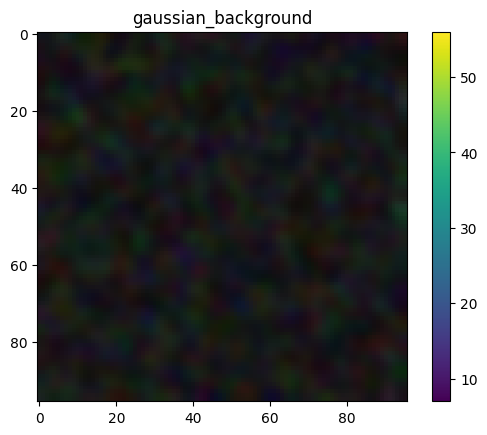

In [8]:
gaussian_background = cv2.GaussianBlur(background, (9, 9), 0)
plt.imshow(gaussian_background)
plt.title(f'gaussian_background')
plt.colorbar()
plt.show()

dataset_name: Football
bboxes :[['player', 1260, 863, 1307, 910, (1088, 1920)], ['player', 1375, 333, 1418, 376, (1088, 1920)], ['player', 1682, 682, 1718, 718, (1088, 1920)], ['player', 766, 491, 817, 542, (1088, 1920)], ['player', 210, 95, 281, 166, (1088, 1920)], ['player', 1435, 11, 1502, 80, (1088, 1920)], ['player', 1692, 422, 1765, 495, (1088, 1920)], ['player', 1271, 645, 1345, 721, (1088, 1920)], ['player', 984, 781, 1027, 827, (1088, 1920)], ['player', 145, 987, 188, 1029, (1088, 1920)], ['player', 1395, 965, 1446, 1012, (1088, 1920)], ['player', 1333, 445, 1387, 499, (1088, 1920)], ['player', 368, 511, 425, 567, (1088, 1920)], ['player', 472, 893, 538, 956, (1088, 1920)], ['player', 1248, 957, 1290, 1000, (1088, 1920)], ['player', 1538, 800, 1587, 851, (1088, 1920)], ['player', 562, 191, 617, 246, (1088, 1920)], ['player', 1616, 511, 1680, 576, (1088, 1920)], ['player', 1052, 443, 1115, 508, (1088, 1920)], ['player', 20, 576, 85, 641, (1088, 1920)], ['player', 234, 716, 274,

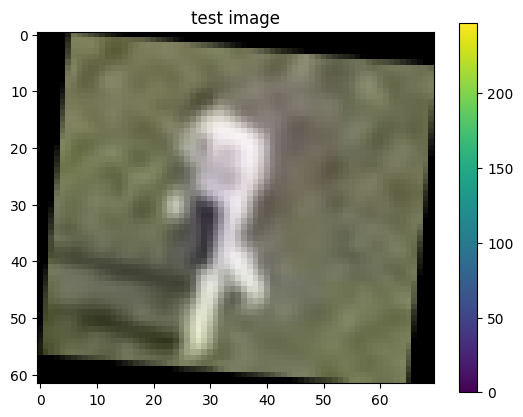

In [11]:
random.seed("123")
# Randomize image order
neg_idx = list(range(len(neg_files)))
pos_idx = list(range(len(pos_files)))
random.shuffle(neg_idx)
random.shuffle(pos_idx)

# size_of_new_image=(2, 2)
# number_of_pos_img = 3

size_of_new_image = (11.34, 20) # for 1088 * 1920
number_of_pos_img = 22         # for 1088 * 1920
new_image = background.copy()
new_image = random_stretch(new_image, size_of_new_image)

# new_image = resize(new_image, size_of_new_image)
image_size = new_image.shape

images = int((len(pos_idx)/number_of_pos_img))

mask_pixel_blur = 3
number_of_negs_width = int((3*size_of_new_image[0])+0.5) #Add code for random number of neg images
number_of_negs_height = int((3*size_of_new_image[1])+0.5)

image = 0
mask = np.zeros_like(new_image)
for width in range(number_of_negs_width):
    for height in range(number_of_negs_height):
        neg_image_idx = ((number_of_negs_height*width)+height+(image*number_of_negs_width*number_of_negs_height)) % neg_counter
        neg_image = plt.imread(os.path.join(folder_path,neg_files[neg_image_idx]))

        starting_pot = (width*neg_image.shape[0], height*neg_image.shape[1])
        neg_width = neg_image.shape[0] if starting_pot[0]+neg_image.shape[0] < new_image.shape[0] else new_image.shape[0]-starting_pot[0]
        neg_height = neg_image.shape[1] if starting_pot[1]+neg_image.shape[1] < new_image.shape[1] else new_image.shape[1]-starting_pot[1]
        mask = update_mask(mask, starting_pot, mask_pixel_blur//2, (neg_width, neg_width))
        new_image[starting_pot[0]:starting_pot[0]+neg_width, starting_pot[1]:starting_pot[1]+neg_height, :] = neg_image[:neg_width, :neg_height, :]

bboxes = []
bbox_padded = []
bboxes_list_padded = []
new_pos_image=np.zeros_like(new_image)
for pos_img in range(number_of_pos_img):
    pos_image_idx = pos_idx[image+(images*pos_img)] #Add code for random number of pos images
    pos_image = plt.imread(os.path.join(folder_path,pos_files[pos_image_idx]))
    temp_pos_image = np.zeros_like(new_pos_image)
    # pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(0.9,1.5), stretch_th=((0.9, 1.1), (0.9, 1.1)),
    #                                          pad_th=0.3, crop_th=(0.0, 0.0), angle_th=0)
    # pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(0.9,1.5), stretch_th=((0.9, 1.1), (0.9, 1.1)),
    #                                          pad_th=0.3, crop_th=(0.0, 0.0), angle_th=0)
    pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(0.9,2.0), stretch_th=((0.9, 1.1), (0.9, 1.1)),
                                             pad_th=0.3, crop_th=(0.0, 0.0), angle_th=90)
    position_of_pos = (random.randint(pos_image_pad.shape[0]//2,image_size[0]-int((pos_image_pad.shape[0]/2)+0.6)), random.randint(pos_image_pad.shape[1]//2,image_size[1]-int((pos_image_pad.shape[1]/2)+0.6)))
    bbox_padded = [position_of_pos[1]-(pos_image_pad.shape[1]//2), position_of_pos[0]-(pos_image_pad.shape[0]//2), position_of_pos[1]+int((pos_image_pad.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image_pad.shape[0]/2)+0.6)]

    # find correct bbox to not overlap
    while not is_valid_bbox(bboxes_list_padded, bbox_padded, 0.15):
        position_of_pos = (random.randint(pos_image_pad.shape[0]//2,image_size[0]-int((pos_image_pad.shape[0]/2)+0.6)), random.randint(pos_image_pad.shape[1]//2,image_size[1]-int((pos_image_pad.shape[1]/2)+0.6)))
        bbox_padded = [position_of_pos[1]-(pos_image_pad.shape[1]//2), position_of_pos[0]-(pos_image_pad.shape[0]//2), position_of_pos[1]+int((pos_image_pad.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image_pad.shape[0]/2)+0.6)]

    # save actual not padded bbox
    bbox = [position_of_pos[1]-(pos_image.shape[1]//2), position_of_pos[0]-(pos_image.shape[0]//2), position_of_pos[1]+int((pos_image.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image.shape[0]/2)+0.6)]
    # save bbox for future overlap
    bboxes_list_padded.append(bbox_padded)
    # patch image
    temp_pos_image[bbox_padded[1]:bbox_padded[3], bbox_padded[0]:bbox_padded[2], :] = pos_image_pad
    pos_image_mask = detect_only_image(temp_pos_image)
    new_pos_image[pos_image_mask==0] = temp_pos_image[pos_image_mask==0]
    # save bbox for annotation function
    bboxes.append(["player", bbox[0], bbox[1], bbox[2], bbox[3], (image_size[0], image_size[1])])

    # border image mask to blue for seemingly be patch with the background
    # easier to make update_mask if is in top-left format and not center
    position_of_pos = (position_of_pos[0]-pos_image_pad.shape[0]//2, position_of_pos[1]-pos_image_pad.shape[1]//2)
    mask = update_mask(mask, position_of_pos, mask_pixel_blur//2, pos_image_pad.shape)#, image_mask=pos_image_mask)

new_image[new_pos_image>0] = new_pos_image[new_pos_image>0]
blurr_image = cv2.GaussianBlur(new_image, (mask_pixel_blur, mask_pixel_blur), 0)
new_image[mask>0]= blurr_image[mask>0]

print(f"dataset_name: {dataset_name}")
print(f"bboxes :{bboxes}")

plt.imshow(pos_image)
plt.title(f'test image')
plt.colorbar()
plt.show()

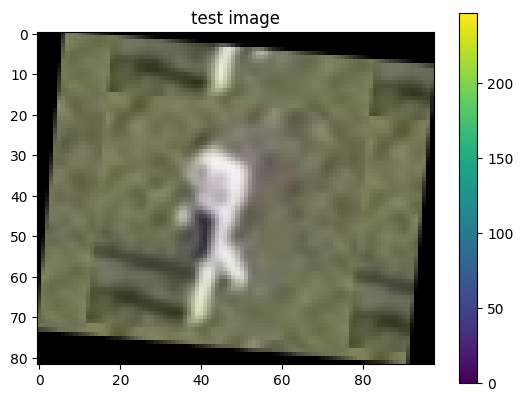

In [20]:
plt.imshow(pos_image_pad)
plt.title(f'test image')
plt.colorbar()
plt.show()

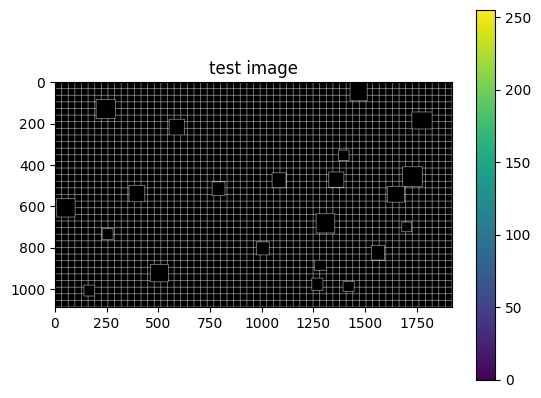

In [21]:
plt.imshow(mask)
plt.title(f'test image')
plt.colorbar()
plt.show()

In [122]:
split = "test"
base_path = "/home/manos/hdd/Binary_Datasets"
dataset_name = "Football"
base_dataset_path = f'{base_path}/{dataset_name}'
folder_path = f'{base_dataset_path}/{split}'
positive_letter = 'f'

# Get a list of all files in the folder
files = os.listdir(folder_path)

# Iterate over the files and perform action on files that start with 'F'
pos_files = []
neg_files = []
for file in files:
    if file.startswith(positive_letter) or file.startswith(str.upper(positive_letter)):
        pos_files.append(file)
    else:
        neg_files.append(file)

pos_counter = len(pos_files)
neg_counter = len(neg_files)
print(f'dataset positive files: {pos_counter}\n'
      f'dataset negative files: {neg_counter}')

dataset positive files: 4517
dataset negative files: 6478


In [126]:
name_prefix = "NEW"
random.seed("123")
# Randomize image order
neg_idx = list(range(len(neg_files)))
pos_idx = list(range(len(pos_files)))
random.shuffle(neg_idx)
random.shuffle(pos_idx)

# size_of_new_image=(2, 2)
# number_of_pos_img = 3

size_of_new_image = (11.34, 20) # for 1088 * 1920
number_of_pos_img = 22         # for 1088 * 1920
new_image = background.copy()
new_image = random_stretch(new_image, size_of_new_image)

# new_image = resize(new_image, size_of_new_image)
image_size = new_image.shape

images = int((len(pos_idx)/number_of_pos_img))

mask_pixel_blur = 3
number_of_negs_width = int((3*size_of_new_image[0])+0.5) #Add code for random number of neg images
number_of_negs_height = int((3*size_of_new_image[1])+0.5)

data_unique_name = 'rand_neg_padded_augmented_size_0.9-2.0'
save_folder_name = f'{base_dataset_path}/{int(96*size_of_new_image[1])}x{int(96*size_of_new_image[0])}_{number_of_pos_img}pos_{number_of_negs_width*number_of_negs_height}neg'
save_folder = f'{save_folder_name}{data_unique_name}/{split}'
save_folder_eval = f'{save_folder_name}{data_unique_name}/eval'
if not os.path.exists(save_folder):
    os.makedirs(f"{save_folder}/images")
    os.makedirs(f"{save_folder}/annotations")
if split == "test":
    eval_ratio = 0/10
else:
    eval_ratio = 1/10
    if not os.path.exists(save_folder_eval):
        os.makedirs(f"{save_folder_eval}/images")
        os.makedirs(f"{save_folder_eval}/annotations")

for image in range(0, images):
    new_image = background.copy()
    new_image = random_stretch(new_image, size_of_new_image)
    mask = np.zeros_like(new_image)
    for width in range(number_of_negs_width):
        for height in range(number_of_negs_height):
            neg_image_idx = ((number_of_negs_height*width)+height+(image*number_of_negs_width*number_of_negs_height)) % neg_counter
            neg_image = plt.imread(os.path.join(folder_path,neg_files[neg_image_idx]))

            # starting_pot = (width*neg_image.shape[0], height*neg_image.shape[1])
            starting_pot = (random.randint(neg_image.shape[0]//2,image_size[0]-int((neg_image.shape[0]/2)+0.6)), random.randint(neg_image.shape[1]//2,image_size[1]-int((neg_image.shape[1]/2)+0.6)))
            neg_width = neg_image.shape[0] if starting_pot[0]+neg_image.shape[0] < new_image.shape[0] else new_image.shape[0]-starting_pot[0]
            neg_height = neg_image.shape[1] if starting_pot[1]+neg_image.shape[1] < new_image.shape[1] else new_image.shape[1]-starting_pot[1]
            mask = update_mask(mask, starting_pot, mask_pixel_blur//2, (neg_width, neg_width))
            new_image[starting_pot[0]:starting_pot[0]+neg_width, starting_pot[1]:starting_pot[1]+neg_height, :] = neg_image[:neg_width, :neg_height, :]

    bboxes = []
    bbox_padded = []
    bboxes_list_padded = []
    new_pos_image=np.zeros_like(new_image)
    for pos_img in range(number_of_pos_img):
        pos_image_idx = pos_idx[image+(images*pos_img)] #Add code for random number of pos images
        pos_image = plt.imread(os.path.join(folder_path,pos_files[pos_image_idx]))
        temp_pos_image = np.zeros_like(new_pos_image)
        # pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(0.9,1.5), stretch_th=((0.9, 1.1), (0.9, 1.1)),
        #                                          pad_th=0.3, crop_th=(0.0, 0.0), angle_th=0)
        # pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(0.9,1.5), stretch_th=((0.9, 1.1), (0.9, 1.1)),
        #                                          pad_th=0.3, crop_th=(0.0, 0.0), angle_th=0)
        pos_image_pad, pos_image = augmentations(pos_image, flip_th=(0, 0.5), scale_th=(0.9,2.0), stretch_th=((0.9, 1.1), (0.9, 1.1)),
                                                 pad_th=0.3, crop_th=(0.0, 0.0), angle_th=10)
        position_of_pos = (random.randint(pos_image_pad.shape[0]//2,image_size[0]-int((pos_image_pad.shape[0]/2)+0.6)), random.randint(pos_image_pad.shape[1]//2,image_size[1]-int((pos_image_pad.shape[1]/2)+0.6)))
        bbox_padded = [position_of_pos[1]-(pos_image_pad.shape[1]//2), position_of_pos[0]-(pos_image_pad.shape[0]//2), position_of_pos[1]+int((pos_image_pad.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image_pad.shape[0]/2)+0.6)]

        # find correct bbox to not overlap
        loop_count = 0
        while not is_valid_bbox(bboxes_list_padded, bbox_padded, 0.15):
            if loop_count >=20:
                break
            position_of_pos = (random.randint(pos_image_pad.shape[0]//2,image_size[0]-int((pos_image_pad.shape[0]/2)+0.6)), random.randint(pos_image_pad.shape[1]//2,image_size[1]-int((pos_image_pad.shape[1]/2)+0.6)))
            bbox_padded = [position_of_pos[1]-(pos_image_pad.shape[1]//2), position_of_pos[0]-(pos_image_pad.shape[0]//2), position_of_pos[1]+int((pos_image_pad.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image_pad.shape[0]/2)+0.6)]
            loop_count += 1


        # save actual not padded bbox
        bbox = [position_of_pos[1]-(pos_image.shape[1]//2), position_of_pos[0]-(pos_image.shape[0]//2), position_of_pos[1]+int((pos_image.shape[1]/2)+0.6), position_of_pos[0]+int((pos_image.shape[0]/2)+0.6)]
        # save bbox for future overlap
        bboxes_list_padded.append(bbox_padded)
        # patch image
        temp_pos_image[bbox_padded[1]:bbox_padded[3], bbox_padded[0]:bbox_padded[2], :] = pos_image_pad
        pos_image_mask = detect_only_image(temp_pos_image)
        new_pos_image[pos_image_mask==0] = temp_pos_image[pos_image_mask==0]
        # save bbox for annotation function
        bboxes.append(["player", bbox[0], bbox[1], bbox[2], bbox[3], (image_size[0], image_size[1])])

        # border image mask to blue for seemingly be patch with the background
        # easier to make update_mask if is in top-left format and not center
        position_of_pos = (position_of_pos[0]-pos_image_pad.shape[0]//2, position_of_pos[1]-pos_image_pad.shape[1]//2)
        # mask = update_mask(mask, position_of_pos, mask_pixel_blur//2, pos_image_pad.shape)#, image_mask=pos_image_mask)
        mask = update_mask(mask, position_of_pos, mask_pixel_blur//2, pos_image_pad.shape, image_mask=pos_image_mask)

    new_image[new_pos_image>0] = new_pos_image[new_pos_image>0]
    blurr_image = cv2.GaussianBlur(new_image, (mask_pixel_blur, mask_pixel_blur), 0)
    new_image[mask>0]= blurr_image[mask>0]

    image_name = f'{name_prefix}{image:05}.bmp'
    final_folder = save_folder_eval if (random.uniform(0, 1) < eval_ratio) else save_folder
    plt.imsave(f"{final_folder}/images/{image_name}", new_image)
    write_to_xml(image_name, bboxes, dataset_name, f"{final_folder}", xml_template='pascal_voc_template.xml')

In [8]:
# Define the path to the dataset
dataset_path = f'{base_dataset_path}/96x96_1pos_9neg_2/train/images'

# Initialize variables to store the sum of means and standard deviations for each channel
mean_sum = np.zeros(3)
std_sum = np.zeros(3)
num_images = 0

# Iterate over all images in the dataset
for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        # Load the image
        image = Image.open(os.path.join(subdir, file))

        # Convert the image to a numpy array
        image_np = np.array(image)

        # Calculate the mean and standard deviation for each channel
        mean_sum += np.mean(image_np, axis=(0, 1))
        std_sum += np.std(image_np, axis=(0, 1))

        # Increment the number of images
        num_images += 1


# Calculate the mean and standard deviation for each channel for the entire dataset
mean = mean_sum / num_images
std = std_sum / num_images

print(f'Mean: {mean}')
print(f'Std: {std}')

NameError: name 'base_dataset_path' is not defined

##Crop & Weed

In [55]:
dataset_main_path = "/media/manos/hdd/allea_datasets/weedDataset"
dataset_new_name = "4k"

In [56]:
augm_dic = {
    "keep_ratio": False,
    "divisible": 0,
    "perspective": 0.0,
    "scale": (1, 1),
    "stretch": ((1, 1), (1, 1)),
    "rotation": 0.0,
    "shear": 0.0,
    "translate": 0.0,
    "flip": 0.0,
    "jitter_box": 0.0,
    "hard_pos": 0.0,
    "hard_pos_ratio": 0.0,
}

In [49]:
temp_img = cv2.imread(f"{dataset_main_path}/train/images/0ab7243432c893122512.jpg")
height, width = temp_img.shape[0], temp_img.shape[1]
target_height = 1088 * 2
target_width = 1920 * 2
dst_shape = (target_width, target_height)
shapeTransformer = ShapeTransform(**augm_dic)

In [39]:
splits = ["train", "val", "test"]
for split in splits:
    dataset_load_path = f"{dataset_main_path}/{split}/images"
    dataset_save_path = f"{dataset_main_path}/{dataset_new_name}/{split}/"
    if not os.path.isdir(dataset_save_path):
        os.makedirs(f"{dataset_save_path}/images")
        os.makedirs(f"{dataset_save_path}/annotations")
    # Run the dataset
    for subdir, dirs, files in os.walk(dataset_load_path):
        for file in files:
            img = cv2.imread(f"{dataset_load_path}/{file}")
            annotation_file = f"{dataset_main_path}/{split}/annotations/{file[:-4]}.xml"
            bboxes = read_annotation_file(annotation_file)
            metadata = {"img": img, "gt_bboxes": [], "gt_labels": [], "gt_areas": []}
            for bbox in bboxes:
                metadata["gt_bboxes"].append(bbox["bbox"])
                metadata["gt_labels"].append(bbox["category_id"])
            metadata["gt_bboxes"] = np.array(metadata["gt_bboxes"])
            metadata = shapeTransformer(metadata, dst_shape)
            metadata["gt_areas"] = [int((bbox[2] - bbox[0])*(bbox[3] - bbox[1])) for bbox in metadata["gt_bboxes"]]
            cv2.imwrite(f"{dataset_save_path}/images/{file}", metadata["img"])
            annotation = [[name, box[0], box[1], box[2], box[3], dst_shape] for name,box in zip(metadata["gt_labels"], metadata["gt_bboxes"])]
            write_to_xml(file, annotation, dataset_new_name, f"{dataset_save_path}", xml_template='pascal_voc_template.xml')

[1884.0, 899.0, 1902.0, 919.0]
[1096.0, 374.0, 1227.0, 507.0]
[2055.0, 850.0, 2096.0, 888.0]
[1083.0, 1994.0, 1160.0, 2053.0]
[402.0, 740.0, 439.0, 788.0]
[295.0, 505.0, 432.0, 692.0]
[227.0, 869.0, 258.0, 898.0]
[1503.0, 591.0, 1539.0, 616.0]
[2059.0, 172.0, 2103.0, 201.0]
[1436.0, 418.0, 1482.0, 461.0]
[1958.0, 1303.0, 2007.0, 1341.0]
[104.0, 1491.0, 137.0, 1529.0]
[410.0, 10.0, 512.0, 111.0]
[2341.0, 587.0, 2423.0, 687.0]
[100.0, 1221.0, 211.0, 1340.0]
[381.0, 1234.0, 436.0, 1297.0]
[530.0, 1948.0, 572.0, 1984.0]
[1311.0, 1916.0, 1360.0, 1939.0]
[1597.0, 1347.0, 1672.0, 1451.0]
[631.0, 467.0, 795.0, 765.0]
[999.0, 1524.0, 1098.0, 1599.0]
[2191.0, 716.0, 2232.0, 765.0]
[1392.0, 1247.0, 1491.0, 1341.0]
[195.0, 941.0, 221.0, 972.0]
[1901.0, 226.0, 1962.0, 304.0]
[1063.0, 1868.0, 1101.0, 1904.0]
[2004.0, 810.0, 2043.0, 852.0]
[592.0, 1554.0, 701.0, 1623.0]
[111.0, 1350.0, 188.0, 1425.0]
[2045.0, 834.0, 2081.0, 875.0]
[1841.0, 929.0, 1907.0, 984.0]
[1407.0, 1175.0, 1461.0, 1220.0]
[1168.

KeyboardInterrupt: 

In [57]:
splits = ["train", "val", "test"]
image_boarders = [((0, 1088), (0, 1920)), ((0, 1088), (1920, 3840)), ((1088, 2176), (0, 1920)), ((1088, 2176), (1920, 3840))]
for split in splits:
    dataset_load_path = f"{dataset_main_path}/4k/{split}/images"
    dataset_save_path = f"{dataset_main_path}/4k/splits/{split}/"
    if not os.path.isdir(dataset_save_path):
        os.makedirs(f"{dataset_save_path}/images")
        os.makedirs(f"{dataset_save_path}/annotations")
    # Run the dataset
    for subdir, dirs, files in os.walk(dataset_load_path):
        for file in files:
            img = cv2.imread(f"{dataset_load_path}/{file}")
            annotation_file = f"{dataset_main_path}/4k/{split}/annotations/{file[:-4]}.xml"
            bboxes = read_annotation_file(annotation_file)
            metadata = {"img": img, "gt_bboxes": [], "new_bboxes": [], "gt_labels": [], "gt_areas": [], "new_areas": []}
            for bbox in bboxes:
                metadata["gt_bboxes"].append(bbox["bbox"])
                metadata["gt_labels"].append(bbox["category_id"])
            metadata["gt_areas"] = [int((bbox[2] - bbox[0])*(bbox[3] - bbox[1])) for bbox in metadata["gt_bboxes"]]
            metadata["gt_bboxes"] = np.array(metadata["gt_bboxes"])

            for idx, image_boarder in enumerate(image_boarders):
                crop_boxes = []
                crop_label = []
                left = image_boarder[1][0]
                right = image_boarder[1][1]
                top = image_boarder[0][0]
                bottom = image_boarder[0][1]

                crop = img[top: bottom, left:right]


                # clip bboxes to crop images
                metadata["new_bboxes"] = [[bbox[0].clip(left, right)+(1920-right), bbox[1].clip(top, bottom)+(1088-bottom), bbox[2].clip(left, right)+(1920-right), bbox[3].clip(top, bottom)+(1088-bottom)] for bbox in metadata["gt_bboxes"]]
                # print(left)
                # print(right)
                # print(top)
                # print(bottom)
                # print(metadata["gt_bboxes"])
                # print(metadata["new_bboxes"])

                metadata["new_areas"] = [int((bbox[2] - bbox[0])*(bbox[3] - bbox[1])) for bbox in metadata["new_bboxes"]]
                # print(metadata["new_areas"])
                # print(metadata["gt_areas"])
                for new_area, gt_area, bbox, label in zip(metadata["new_areas"], metadata["gt_areas"], metadata["new_bboxes"], metadata["gt_labels"]):
                    if new_area<50:
                        continue
                    if new_area<(gt_area/5):
                        continue
                    crop_label.append(label)
                    crop_boxes.append(bbox)
                # print(crop_boxes)
                # break
                if len(crop_label) > 0:
                    cv2.imwrite(f"{dataset_save_path}/images/{idx}_{file}", crop)
                    annotation = [[name, box[0], box[1], box[2], box[3], (1920, 1088)] for name,box in zip(crop_label, crop_boxes)]
                    write_to_xml(f"{idx}_{file}", annotation, "1080p_from_4k", f"{dataset_save_path}", xml_template='pascal_voc_template.xml')
                # break
            # break
        # break
    # break

In [18]:
# Define the path to the dataset
dataset_path = f'/media/manos/hdd/allea_datasets/weedDataset/1080p/eval/small_images/images'

# Initialize variables to store the sum of means and standard deviations for each channel
mean_sum = np.zeros(3)
std_sum = np.zeros(3)
num_images = 0

# Iterate over all images in the dataset
for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        # Load the image
        image = Image.open(os.path.join(subdir, file))
        # Convert the image to a numpy array
        image_np = np.array(image)

        # Calculate the mean and standard deviation for each channel
        mean_sum += np.mean(image_np, axis=(0, 1))
        std_sum += np.std(image_np, axis=(0, 1))

        # Increment the number of images
        num_images += 1


# Calculate the mean and standard deviation for each channel for the entire dataset
mean = mean_sum / num_images
std = std_sum / num_images

print(f'Mean, Std: [[{math.ceil(mean[0]*100)/100}, {math.ceil(mean[1]*100)/100}, {math.ceil(mean[2]*100)/100}], [{math.ceil(std[0]*100)/100}, {math.ceil(std[1]*100)/100}, {math.ceil(std[2]*100)/100}]]')

Mean, Std: [[99.63, 105.73, 100.9], [34.94, 30.39, 29.34]]


In [5]:
print(f'Mean, Std: [[{math.ceil(mean[0]*100)/100}, {math.ceil(mean[1]*100)/100}, {math.ceil(mean[2]*100)/100}], [{math.ceil(std[0]*100)/100}, {math.ceil(std[1]*100)/100}, {math.ceil(std[2]*100)/100}]]')

Mean, Std: [[96.04, 101.39, 94.85], [36.38, 32.02, 30.28]]


In [19]:
# Define the path to the dataset
dataset_path = f'/media/manos/hdd/allea_datasets/weedDataset/1080p/eval/annotations'

# Initialize dataframe
columns = ["xmin", "ymin", "xmax", "ymax","width", "height", "area", "name"]
df = pd.DataFrame([], columns=columns)

# Iterate over all annotations in the dataset
for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        # Load the image
        bboxes = read_annotation_file(os.path.join(subdir, file))
        bboxes = [[bbox["bbox"][0], bbox["bbox"][1], bbox["bbox"][2], bbox["bbox"][3], bbox["bbox"][2]-bbox["bbox"][0], bbox["bbox"][3]-bbox["bbox"][1], (bbox["bbox"][2]-bbox["bbox"][0])*(bbox["bbox"][3]-bbox["bbox"][1]), file] for bbox in bboxes]

        # Convert the list into pandas
        df = pd.concat([df, pd.DataFrame(bboxes, columns=columns)], axis=0)

# Calculate the mean and standard deviation of annotations
print("mean || std || max || min")
display(df.mean(numeric_only=True), df.std(numeric_only=True), df.max(numeric_only=True), df.min(numeric_only=True))

mean || std || max || min


xmin       934.785768
ymin       538.646664
xmax       988.170573
ymax       573.879323
width       53.384804
height      35.232659
area      3205.409847
dtype: float64

xmin        543.581874
ymin        310.351641
xmax        544.077740
ymax        309.159233
width        50.004796
height       32.616543
area      10516.823060
dtype: float64

xmin        1909.0
ymin        1077.0
xmax        1919.0
ymax        1087.0
width        912.0
height       600.0
area      303048.0
dtype: float64

xmin       0.0
ymin       0.0
xmax      10.0
ymax      10.0
width      8.0
height     5.0
area      54.0
dtype: float64

In [20]:
print(df.shape[0])
# df_small = df[df["area"]<=200000]
df_small = df[df["width"]<412]
df_small = df_small[df_small["height"]<412]
# df_small = df_small[df_small["area"]<=412]
print(df_small.shape[0])

10582
10557


In [21]:
print("mean || std || max || min")
display(df_small.mean(numeric_only=True), df_small.std(numeric_only=True), df_small.max(numeric_only=True), df_small.min(numeric_only=True))

mean || std || max || min


xmin       935.070569
ymin       538.890120
xmax       987.365066
ymax       573.528180
width       52.294497
height      34.638060
area      2858.786587
dtype: float64

xmin       543.503446
ymin       310.426548
xmax       543.800078
ymax       309.154408
width       44.383849
height      29.625258
area      6813.247640
dtype: float64

xmin        1909.0
ymin        1077.0
xmax        1919.0
ymax        1087.0
width        410.0
height       404.0
area      149480.0
dtype: float64

xmin       0.0
ymin       0.0
xmax      10.0
ymax      10.0
width      8.0
height     5.0
area      54.0
dtype: float64

In [22]:
df_small

,xmin,ymin,xmax,ymax,width,height,area,name
0,344.0,301.0,534.0,418.0,190.0,117.0,22230.0,109eaff999cd87770f25.xml
1,1029.0,120.0,1119.0,191.0,90.0,71.0,6390.0,109eaff999cd87770f25.xml
2,319.0,134.0,417.0,192.0,98.0,58.0,5684.0,109eaff999cd87770f25.xml
3,858.0,35.0,957.0,63.0,99.0,28.0,2772.0,109eaff999cd87770f25.xml
4,1433.0,686.0,1455.0,699.0,22.0,13.0,286.0,109eaff999cd87770f25.xml
...,...,...,...,...,...,...,...,...
2,161.0,269.0,189.0,283.0,28.0,14.0,392.0,3342bbb69668505a55a5.xml
3,0.0,1045.0,27.0,1058.0,27.0,13.0,351.0,3342bbb69668505a55a5.xml
4,697.0,150.0,723.0,163.0,26.0,13.0,338.0,3342bbb69668505a55a5.xml
5,814.0,10.0,850.0,29.0,36.0,19.0,684.0,3342bbb69668505a55a5.xml


In [23]:
df_small.reset_index(drop=True).idxmax(numeric_only=True)

xmin       231
ymin       114
xmax        24
ymax       341
width     8244
height    7949
area      7949
dtype: int64

In [24]:
dell_df = df[df["width"]>=412]
dell_df = dell_df[dell_df["height"]>=412]

dell_df_2 = dell_df.sort_values(by=["name", "area"],  ascending=[False, False]).reset_index(drop=True)
print(dell_df.shape[0])
droped_df = dell_df_2.drop(labels=0, axis=0)
display(dell_df, dell_df_2, droped_df)

3


,xmin,ymin,xmax,ymax,width,height,area,name
205,1367.0,538.0,1919.0,1087.0,552.0,549.0,303048.0,ad27545d0572a0902e1f.xml
0,1393.0,175.0,1919.0,592.0,526.0,417.0,219342.0,633a5d2d476411954de1.xml
5,100.0,479.0,542.0,931.0,442.0,452.0,199784.0,869a211d0ad0ef57530e.xml


,xmin,ymin,xmax,ymax,width,height,area,name
0,1367.0,538.0,1919.0,1087.0,552.0,549.0,303048.0,ad27545d0572a0902e1f.xml
1,100.0,479.0,542.0,931.0,442.0,452.0,199784.0,869a211d0ad0ef57530e.xml
2,1393.0,175.0,1919.0,592.0,526.0,417.0,219342.0,633a5d2d476411954de1.xml


,xmin,ymin,xmax,ymax,width,height,area,name
1,100.0,479.0,542.0,931.0,442.0,452.0,199784.0,869a211d0ad0ef57530e.xml
2,1393.0,175.0,1919.0,592.0,526.0,417.0,219342.0,633a5d2d476411954de1.xml


In [25]:
list(np.array(dell_df.iloc[0]))

[1367.0,
 538.0,
 1919.0,
 1087.0,
 552.0,
 549.0,
 303048.0,
 'ad27545d0572a0902e1f.xml']

In [41]:
new_image_w = 412
new_image_h = 412
splits = ["train", "eval", "test"]
# split = "test"
cls_name = "weed"

for split in splits:
    # Define the path to the dataset
    dataset_path = f'/media/manos/hdd/allea_datasets/weedDataset/1080p/{split}'


    # Initialize dataframe
    columns = ["xmin", "ymin", "xmax", "ymax","width", "height", "area", "name"]
    df = pd.DataFrame([], columns=columns)
    # Iterate over all annotations in the dataset
    for subdir, dirs, files in os.walk(f"{dataset_path}/annotations"):
        for file in files:
            # Load the image
            bboxes = read_annotation_file(os.path.join(subdir, file))
            bboxes = [[bbox["bbox"][0], bbox["bbox"][1], bbox["bbox"][2], bbox["bbox"][3], bbox["bbox"][2]-bbox["bbox"][0], bbox["bbox"][3]-bbox["bbox"][1], (bbox["bbox"][2]-bbox["bbox"][0])*(bbox["bbox"][3]-bbox["bbox"][1]), file] for bbox in bboxes]

            # Convert the list into pandas
            df = pd.concat([df, pd.DataFrame(bboxes, columns=columns)], axis=0)
    # Find new df without big annotations
    df_small = df[df["width"]<new_image_w]
    df_small = df_small[df_small["height"]<new_image_h].reset_index(drop=True)


    save_path = f'{dataset_path}/small_images'
    os.makedirs(f'{save_path}/images', exist_ok=True)
    os.makedirs(f'{save_path}/annotations', exist_ok=True)
    # short images and areas to run for each file
    df_small.sort_values(by=["name", "area"], ascending=[True, False], inplace=True)
    # find unique files and make the dataframes for each one into a list
    names = [np.array(df_small.iloc[idx])[7] for idx in range(df_small.shape[0])]
    unique_names = set(names)
    list_of_dfs = [df_small[df_small["name"]==unique_name].reset_index(drop=True) for unique_name in unique_names]

    # run list of each file
    for file in list_of_dfs:
        # take name for save
        start_name = file.iloc[0]["name"][:-4]
        starting_image = cv2.imread(f"{dataset_path}/images/{start_name}.jpg")
        h, w = starting_image.shape[:2]
        count = 0
        # run while there is still annotations for the image
        while file.shape[0]>0:
            # take the biggest annotation
            init_bbox = list(np.array(file.iloc[0]))
            # randomly put annotation into the new image
            random_width = int(random.uniform(0, 1)*(new_image_w-init_bbox[4]))
            random_height = int(random.uniform(0, 1)*(new_image_h-init_bbox[5]))
            xmin = int(init_bbox[0]-random_width)
            ymin = int(init_bbox[1]-random_height)
            xmax = xmin+new_image_w
            ymax = ymin+new_image_h

            # find new image into the boundaries of original image
            if xmin < 0 :
                xmin = 0
                xmax = new_image_w
            if ymin < 0 :
                ymin = 0
                ymax = new_image_h
            if xmax > w :
                xmax = w
                xmin = w - new_image_w
            if ymax > h :
                ymax = h
                ymin = h - new_image_h

            #check that new image is always new width and height
            if (xmax-xmin) != new_image_w:
                print(f"width: {(xmax-xmin)}")
                print(init_bbox)
                print([xmin, xmax, ymin, ymax])
            if (ymax-ymin) != new_image_h:
                print(f"height: {(ymax-ymin)}")
                print(init_bbox)
                print([xmin, xmax, ymin, ymax])

            init_window = [xmin, ymin, xmax, ymax]
            new_image = starting_image[ymin:ymax, xmin:xmax]
            # Put it in coordinates of new window
            image_annot_list = [[cls_name, init_bbox[0] - init_window[0], init_bbox[1] - init_window[1],
                                 init_bbox[2] - init_window[0], init_bbox[3] - init_window[1], (new_image_w, new_image_h)]]
            drop_list = [0]
            # Run into all bboxes in the image
            for bbox_idx in range(1, file.shape[0]):
                bbox = list(np.array(file.iloc[bbox_idx]))[:4]
                old_area = list(np.array(file.iloc[bbox_idx]))[6]

                # Crop all annotations outside of window
                if (bbox[0] >= xmax) or (bbox[1] >= ymax) or (bbox[2] <= xmin) or (bbox[3] <= ymin):
                    continue
                # find annotations coordinates inside the window and the new area
                new_bbox_xmin = bbox[0] if bbox[0] >= xmin else xmin
                new_bbox_ymin = bbox[1] if bbox[1] >= ymin else ymin
                new_bbox_xmax = bbox[2] if bbox[2] <= xmax else xmax
                new_bbox_ymax = bbox[3] if bbox[3] <= ymax else ymax
                new_area = (new_bbox_ymax-new_bbox_ymin)*(new_bbox_xmax-new_bbox_xmin)
                if new_area <= 0:
                    print("find neg area")
                if new_area > 0:
                    percentage_area = new_area/old_area
                    if percentage_area > 1:
                        print(f"percentage area: {percentage_area}")
                        print(f"init_window:         {init_window}")
                        print(f"bbox with problem:   {np.array(file.iloc[bbox_idx])}")
                        print(f"new bbox:            {[new_bbox_xmin, new_bbox_ymin, new_bbox_xmax, new_bbox_ymax]}")
                        print(f"old area:            {old_area}")
                        print(f"new area:            {new_area}")
                    if percentage_area>0.5:
                        # Check is miss anything
                        if (new_bbox_ymax-ymin) <= 0:
                            print("new bbox HEIGHT is NEGATIVE")
                            print(f"init bbox:           {init_bbox}")
                            print(f"added width, height: {[random_width, random_height]}")
                            print(f"init_window:         {init_window}")
                            print(f"bbox with problem:   {np.array(file.iloc[bbox_idx])}")
                            print(f"new bbox:            {[new_bbox_xmin, new_bbox_ymin, new_bbox_xmax, new_bbox_ymax]}")
                            print(f"old area:            {old_area}")
                            print(f"new area:            {new_area}")
                        if (new_bbox_xmax-xmin) <= 0:
                            print("new bbox WIDTH is NEGATIVE")
                            print(f"init bbox:           {init_bbox}")
                            print(f"added width, height: {[random_width, random_height]}")
                            print(f"init_window:         {init_window}")
                            print(f"bbox with problem:   {np.array(file.iloc[bbox_idx])}")
                            print(f"new bbox:            {[new_bbox_xmin, new_bbox_ymin, new_bbox_xmax, new_bbox_ymax]}")
                            print(f"old area:            {old_area}")
                            print(f"new area:            {new_area}")
                        # Put it in coordinates of new window
                        new_bbox = [cls_name, new_bbox_xmin-xmin, new_bbox_ymin-ymin, new_bbox_xmax-xmin, new_bbox_ymax-ymin, (new_image_w, new_image_h)]
                        if new_bbox[1] < 0 or new_bbox[2] < 0 or new_bbox[3] < 0 or new_bbox[4] < 0:
                            print(new_bbox)
                        drop_list.append(bbox_idx)
                        image_annot_list.append(new_bbox)
            file = file.drop(labels=drop_list, axis=0).reset_index(drop=True)
            # Save image-annotations
            write_to_xml(f"{count}_{start_name}.jpg", image_annot_list, "412_from_1080p", f"{save_path}", xml_template='pascal_voc_template.xml')
            cv2.imwrite(f"{save_path}/images/{count}_{start_name}.jpg", new_image)
            count += 1

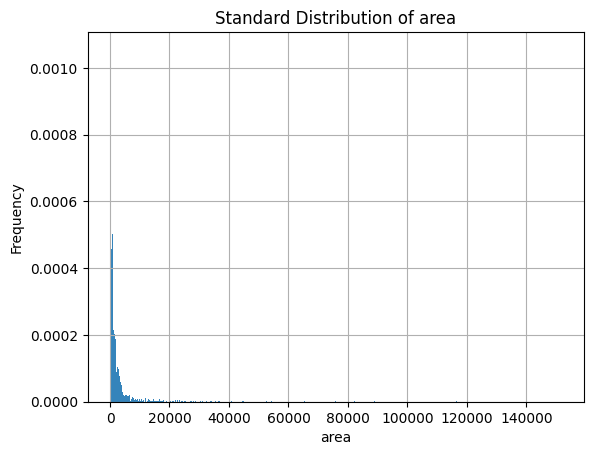

In [44]:
column_name = 'area'
column_data = df_small[column_name]
plt.hist(column_data, bins=10000, density=True, alpha=0.9)  # Adjust the number of bins as needed
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Standard Distribution of {}'.format(column_name))
plt.grid(True)
plt.show()